In [1]:
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import sys
import numpy as np

In [2]:
# Values for data cleaning / imputation
md_threshold = 80
impute_n = 3

### OECD Datasets Preparation

In [3]:
# Load all

# OECD HCQI // Healthcare Quality Indicators
hcqi = pd.read_csv("../OECD/HEALTH_HCQI_22092023205825625.csv")

# OECD LVNG // Non-Medical Determinants of Health
lvng = pd.read_csv("../OECD/HEALTH_LVNG_25092023023230295.csv")

# OECD STAT // Health Statistics
stat = pd.read_csv("../OECD/HEALTH_STAT_25092023023520080.csv")

# OECD PROT // Social Protection
prot = pd.read_csv("../OECD/HEALTH_PROT_22092023205920251.csv")

# OECD DEMR // Demographics
demr = pd.read_csv("../OECD/HEALTH_DEMR_25092023023656863.csv")

# OECD ECOR // Economic References
ecor = pd.read_csv("../OECD/HEALTH_ECOR_28092023052908229.csv")

oecd_datasets = [hcqi, lvng, stat, prot, demr, ecor]

In [4]:
# Preliminary Cleaning


def clean_oecd_df(df):
    """Removes redundant or unneeded columns from OECD datasets"""

    df.drop(["Flag Codes", "Flags"], axis=1, inplace=True)
    if "YEA" in df.columns:
        df.drop(["YEA"], axis=1, inplace=True)
    else:
        df.drop(["PER"], axis=1, inplace=True)

    return df


oecd_datasets = [clean_oecd_df(x) for x in oecd_datasets]

# Renaming columns in HCQI to match other datasets
hcqi.rename(
    columns={"Indicator": "Variable", "IND": "VAR", "Periods": "Year"}, inplace=True
)

hcqi.head()

,COU,Country,Year,VAR,Variable,GEN,Gender,AGE,Age Group,VAL,Value,Value.1
0,AUS,Australia,2011,ADMRASTH,Asthma hospital admission,M,Male,TOTAL_15,15 years old and over,AS_STD_RATE_MPOP,Age-sex standardised rate per 100 000 population,40.4
1,AUS,Australia,2011,ADMRASTH,Asthma hospital admission,M,Male,TOTAL_15,15 years old and over,LOW_CI,Lower confidence interval,39.1
2,AUS,Australia,2011,ADMRASTH,Asthma hospital admission,M,Male,TOTAL_15,15 years old and over,UP_CI,Upper confidence interval,41.8
3,AUS,Australia,2012,ADMRASTH,Asthma hospital admission,M,Male,TOTAL_15,15 years old and over,AS_STD_RATE_MPOP,Age-sex standardised rate per 100 000 population,36.8
4,AUS,Australia,2012,ADMRASTH,Asthma hospital admission,M,Male,TOTAL_15,15 years old and over,LOW_CI,Lower confidence interval,35.5


In [5]:
# Add unit to indicators to handle duplicates with same name but different units
for dat in oecd_datasets[1:]:
    for var in dat["VAR"].unique():
        if (
            dat[dat["VAR"] == var]["UNIT"].nunique() > 1
        ):  # Check for existence of duplicates
            cond = dat["VAR"] == var  # Modify indicator names
            dat["VAR"] = np.where(cond, dat["VAR"] + "_" + dat["UNIT"], dat["VAR"])

In [6]:
# Reformatting HCQI data for merging

# Rename indicators with more info and then drop unnecessary columns
hcqi["VAR"] = hcqi["VAR"] + "_" + hcqi["GEN"] + "_" + hcqi["AGE"] + "_" + hcqi["VAL"]
hcqi.drop(
    ["Country", "Variable", "GEN", "Gender", "AGE", "Age Group", "VAL", "Value"],
    axis=1,
    inplace=True,
)
hcqi.rename(columns={"Value.1": "Value"}, inplace=True)

hcqi.head()

,COU,Year,VAR,Value
0,AUS,2011,ADMRASTH_M_TOTAL_15_AS_STD_RATE_MPOP,40.4
1,AUS,2011,ADMRASTH_M_TOTAL_15_LOW_CI,39.1
2,AUS,2011,ADMRASTH_M_TOTAL_15_UP_CI,41.8
3,AUS,2012,ADMRASTH_M_TOTAL_15_AS_STD_RATE_MPOP,36.8
4,AUS,2012,ADMRASTH_M_TOTAL_15_LOW_CI,35.5


In [7]:
# Merging of OECD datasets

merged_df = pd.concat(oecd_datasets[:])
merged_df = merged_df[["VAR", "COU", "Year", "Value"]]
merged_df.rename(columns={"COU": "Country"}, inplace=True)

merged_df.head()

,VAR,Country,Year,Value
0,ADMRASTH_M_TOTAL_15_AS_STD_RATE_MPOP,AUS,2011,40.4
1,ADMRASTH_M_TOTAL_15_LOW_CI,AUS,2011,39.1
2,ADMRASTH_M_TOTAL_15_UP_CI,AUS,2011,41.8
3,ADMRASTH_M_TOTAL_15_AS_STD_RATE_MPOP,AUS,2012,36.8
4,ADMRASTH_M_TOTAL_15_LOW_CI,AUS,2012,35.5


In [8]:
# Transforming data into wide format

merged_df = (
    pd.pivot_table(merged_df, index=["Country", "Year"], columns="VAR", values="Value")
    .reset_index()
    .rename_axis(None, axis=1)
)

merged_df.head()

,Country,Year,ACOLALCT,ADMDEALL_F_TOTAL_CRUDE_RATE_MORT,ADMDEALL_M_TOTAL_CRUDE_RATE_MORT,ADMDEALL_T_TOTAL_CRUDE_RATE_MORT,ADMDEALZ_F_TOTAL_CRUDE_RATE_MORT,ADMDEALZ_M_TOTAL_CRUDE_RATE_MORT,ADMDEALZ_T_TOTAL_CRUDE_RATE_MORT,ADMDECAN_F_TOTAL_CRUDE_RATE_MORT,...,TOBATBCT_YNGPPFPF,TOBATBCT_YNGPPHPH,TOBATBCT_YNGPPTPC,TPRIBASI,VAPEVAPA_VAPREGPC,VAPEVAPA_VAPREGPF,VAPEVAPA_VAPREGPH,VAPEVAPY_VAPREGPC,VAPEVAPY_VAPREGPF,VAPEVAPY_VAPREGPH
0,ARG,2010,8.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ARG,2011,7.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ARG,2012,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ARG,2013,8.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ARG,2014,7.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Investigating Missing Data

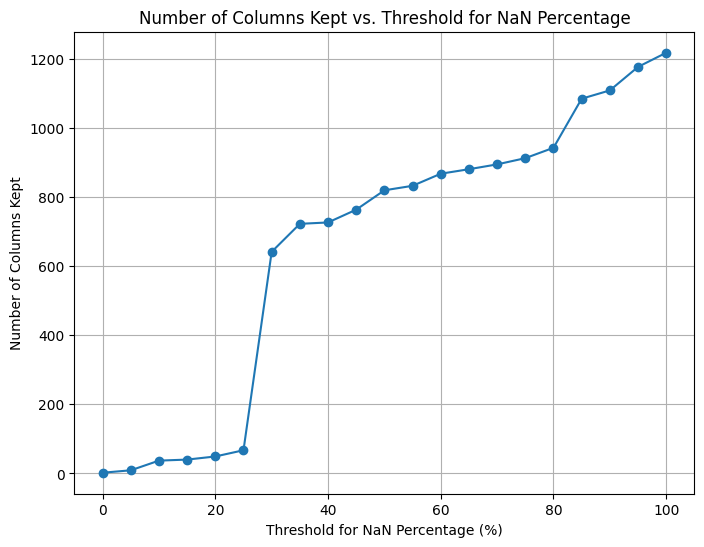

In [9]:
# Drop columns where the number of NaN's is greater than a given threshold %
# First determine what that threshold should be

# Range of thresholds to test
thresholds = range(0, 101, 5)  # Vary from 0% to 100% in increments of 5%

# Calculate the percentage of NaNs per column
nan_percentage = (merged_df.isna().mean() * 100).round(2)

# Initialize lists to store results
threshold_values = []
kept_columns = []

# Calculate the number of columns kept for each threshold
for threshold in thresholds:
    columns_to_drop = nan_percentage > threshold
    kept_columns_count = sum(~columns_to_drop)  # Count columns that are not dropped
    threshold_values.append(threshold)
    kept_columns.append(kept_columns_count)

# Create a plot
plt.figure(figsize=(8, 6))
plt.plot(threshold_values, kept_columns, marker="o", linestyle="-")
plt.title("Number of Columns Kept vs. Threshold for NaN Percentage")
plt.xlabel("Threshold for NaN Percentage (%)")
plt.ylabel("Number of Columns Kept")
plt.grid(True)
plt.show()

In [10]:
# Missing data percentage of Maternal Mortality indicator
print((merged_df["MATIMATM"].isna().mean() * 100).round(2))

31.35


In [11]:
# Create a boolean mask for columns with more than the threshold percentage of NaNs
columns_to_drop = nan_percentage > md_threshold

# Drop the columns with more than the threshold percentage of NaNs
df_cleaned = merged_df.drop(columns=nan_percentage[columns_to_drop].index)
df_cleaned

,Country,Year,ACOLALCT,ADMRASTH_F_TOTAL_15_AS_STD_RATE_MPOP,ADMRASTH_F_TOTAL_15_LOW_CI,ADMRASTH_F_TOTAL_15_UP_CI,ADMRASTH_M_TOTAL_15_AS_STD_RATE_MPOP,ADMRASTH_M_TOTAL_15_LOW_CI,ADMRASTH_M_TOTAL_15_UP_CI,ADMRASTH_T_TOTAL_15_AS_STD_RATE_MPOP,...,STRUSFPL_TOTPOPTX,TOBATBCT_GRPPERQT,TOBATBCT_NBPFUMNB,TOBATBCT_PDLSFMTF,TOBATBCT_PDLSHOTH,TOBATBCT_PDLSTOTX,TOBATBCT_YNGPPFPF,TOBATBCT_YNGPPHPH,TOBATBCT_YNGPPTPC,TPRIBASI
0,ARG,2010,8.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.2,NaN,NaN,22.8,34.2,28.3,NaN,NaN,NaN,NaN
1,ARG,2011,7.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ARG,2012,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ARG,2013,8.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ARG,2014,7.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
652,ZAF,2018,7.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.9,NaN,NaN,6.9,34.3,20.3,NaN,NaN,NaN,NaN
653,ZAF,2019,7.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.0,NaN,NaN,6.7,34.5,20.2,NaN,NaN,NaN,NaN
654,ZAF,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.1,NaN,NaN,6.5,34.6,20.2,NaN,NaN,NaN,NaN
655,ZAF,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Add Maternal Mortality data from WB if it doesn't exist for OECD
wb = pd.read_csv("../WorldBankDatasets/Gender_WorldBankData.csv")[
    ["Country", "Year", "SH.STA.MMRT.NE"]
]
wb.rename(columns={"SH.STA.MMRT.NE": "MATIMATM"}, inplace=True)

# Set indices and fillna
wb = wb.set_index(["Country", "Year"])
df_cleaned = df_cleaned.set_index(["Country", "Year"])
df_cleaned["MATIMATM"].fillna(wb["MATIMATM"], inplace=True)

# Reset
df_cleaned.reset_index(inplace=True)

df_cleaned = df_cleaned.dropna(
    subset=["MATIMATM"]
)  # Drop rows still without MM indicator

### Investigating correlations / data leakage

In [13]:
# Import utility functions
sys.path.append("../utility_functions")
from ind_utility_functions import get_ind_name, get_ind_info

In [14]:
# Get values for top 10 correlations with Maternal Mortality
top_10 = df_cleaned.iloc[:, 2:].corr()["MATIMATM"].sort_values(ascending=False)[1:11]

top_10

PLYLGROS             0.947580
CICDGROS_TXCMFETF    0.946639
CICDGROS_TXCRUDTF    0.942195
CICDHOCD_TXCRUDTX    0.875926
CICDHOCD_TXCRUDTH    0.874925
PLYLHOCD_ANNTOTTX    0.873505
PLYLHOCD_ANNHOMTH    0.871137
CICDHOCD_TXCMILTX    0.868455
CICDHOCD_TXCMHOTH    0.865290
PLYLHOCD_ANNFEMTF    0.851039
Name: MATIMATM, dtype: float64

In [15]:
# Get info for correlations
[(get_ind_name(i), get_ind_info(i)) for i in top_10.index]

[('Complications of pregnancy, childbirth and the puerperium',
  'Years lost, /100 000 females, aged 75 years old'),
 ('Pregnancy, childbirth and the puerperium',
  'Deaths per 100 000 females (standardised rates)'),
 ('Pregnancy, childbirth and the puerperium',
  'Deaths per 100 000 females (crude rates)'),
 ('Assault', 'Deaths per 100 000 population (crude rates)'),
 ('Assault', 'Deaths per 100 000 males (crude rates)'),
 ('Assault', 'Years lost, /100 000 population, aged 75 years old'),
 ('Assault', 'Years lost, /100 000 males, aged 75 years old'),
 ('Assault', 'Deaths per 100 000 population (standardised rates)'),
 ('Assault', 'Deaths per 100 000 males (standardised rates)'),
 ('Assault', 'Years lost, /100 000 females, aged 75 years old')]

In [16]:
# Dropping variables due to possible data leakage
leakage = ["PLYLGROS", "CICDGROS_TXCMFETF", "CICDGROS_TXCRUDTF"]
df_cleaned.drop(columns=leakage, inplace=True)

### Rescale and Impute Data

In [17]:
# Scale data
scaler = MinMaxScaler()

# Define the columns to include in scaling and imputation
columns_to_scale = df_cleaned.columns[2:]  # Exclude the first two columns
columns_to_exclude = ["MATIMATM"]  # Add the maternal mortality column to exclude

# Separate the columns to scale and exclude
columns_to_scale = [col for col in columns_to_scale if col not in columns_to_exclude]

X = df_cleaned[columns_to_scale]
X = scaler.fit_transform(X)

# Impute missing values using KNNImputer
knn_imputer = KNNImputer(n_neighbors=impute_n)
imputed_data = knn_imputer.fit_transform(X)
df_cleaned[columns_to_scale] = imputed_data

imputed_df = df_cleaned.copy()
imputed_df

,Country,Year,ACOLALCT,ADMRASTH_F_TOTAL_15_AS_STD_RATE_MPOP,ADMRASTH_F_TOTAL_15_LOW_CI,ADMRASTH_F_TOTAL_15_UP_CI,ADMRASTH_M_TOTAL_15_AS_STD_RATE_MPOP,ADMRASTH_M_TOTAL_15_LOW_CI,ADMRASTH_M_TOTAL_15_UP_CI,ADMRASTH_T_TOTAL_15_AS_STD_RATE_MPOP,...,STRUSFPL_TOTPOPTX,TOBATBCT_GRPPERQT,TOBATBCT_NBPFUMNB,TOBATBCT_PDLSFMTF,TOBATBCT_PDLSHOTH,TOBATBCT_PDLSTOTX,TOBATBCT_YNGPPFPF,TOBATBCT_YNGPPHPH,TOBATBCT_YNGPPTPC,TPRIBASI
13,AUS,2010,0.681481,0.438622,0.447901,0.429774,0.356844,0.374339,0.345149,0.415388,...,0.328947,0.392509,0.744186,0.472574,0.296089,0.381974,0.371069,0.281174,0.320442,0.975265
14,AUS,2011,0.666667,0.470645,0.480000,0.461392,0.386473,0.404762,0.375000,0.446931,...,0.337719,0.375896,0.622739,0.386779,0.254190,0.307582,0.321803,0.244499,0.276243,0.975265
15,AUS,2012,0.651852,0.437652,0.446914,0.428980,0.351691,0.369048,0.339552,0.413043,...,0.350877,0.372779,0.622739,0.386779,0.254190,0.307582,0.321803,0.244499,0.276243,0.975265
16,AUS,2013,0.644444,0.407569,0.416790,0.398951,0.332367,0.349206,0.320896,0.386189,...,0.364035,0.351000,0.573643,0.354430,0.243017,0.283262,0.333333,0.254279,0.284530,0.975265
17,AUS,2014,0.629630,0.448326,0.457778,0.438990,0.336232,0.354167,0.325560,0.415601,...,0.377193,0.313143,0.622739,0.386779,0.254190,0.307582,0.321803,0.244499,0.276243,0.975265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,USA,2015,0.562963,0.371503,0.386667,0.356689,0.319163,0.344907,0.299751,0.356351,...,0.385965,0.487374,0.604651,0.329114,0.173184,0.214592,0.229560,0.158924,0.185083,0.653710
637,USA,2016,0.570370,0.267831,0.281481,0.254528,0.204831,0.228175,0.189366,0.248082,...,0.399123,0.462878,0.604651,0.320675,0.201117,0.231760,0.251572,0.200489,0.220994,0.664311
639,USA,2018,0.570370,0.252790,0.266173,0.239752,0.194203,0.217262,0.178172,0.235294,...,0.434211,0.415668,0.589147,0.261603,0.153631,0.167382,0.176101,0.063570,0.110497,0.643110
640,USA,2019,0.577778,0.249393,0.262716,0.236416,0.198068,0.221230,0.181903,0.234015,...,0.456140,0.390282,0.573643,0.299578,0.159218,0.193133,0.150943,0.080685,0.107735,0.611307


In [18]:
# Cast Year to an integer data type
imputed_df["Year"] = imputed_df["Year"].astype(int)

imputed_df.head()

,Country,Year,ACOLALCT,ADMRASTH_F_TOTAL_15_AS_STD_RATE_MPOP,ADMRASTH_F_TOTAL_15_LOW_CI,ADMRASTH_F_TOTAL_15_UP_CI,ADMRASTH_M_TOTAL_15_AS_STD_RATE_MPOP,ADMRASTH_M_TOTAL_15_LOW_CI,ADMRASTH_M_TOTAL_15_UP_CI,ADMRASTH_T_TOTAL_15_AS_STD_RATE_MPOP,...,STRUSFPL_TOTPOPTX,TOBATBCT_GRPPERQT,TOBATBCT_NBPFUMNB,TOBATBCT_PDLSFMTF,TOBATBCT_PDLSHOTH,TOBATBCT_PDLSTOTX,TOBATBCT_YNGPPFPF,TOBATBCT_YNGPPHPH,TOBATBCT_YNGPPTPC,TPRIBASI
13,AUS,2010,0.681481,0.438622,0.447901,0.429774,0.356844,0.374339,0.345149,0.415388,...,0.328947,0.392509,0.744186,0.472574,0.296089,0.381974,0.371069,0.281174,0.320442,0.975265
14,AUS,2011,0.666667,0.470645,0.480000,0.461392,0.386473,0.404762,0.375000,0.446931,...,0.337719,0.375896,0.622739,0.386779,0.254190,0.307582,0.321803,0.244499,0.276243,0.975265
15,AUS,2012,0.651852,0.437652,0.446914,0.428980,0.351691,0.369048,0.339552,0.413043,...,0.350877,0.372779,0.622739,0.386779,0.254190,0.307582,0.321803,0.244499,0.276243,0.975265
16,AUS,2013,0.644444,0.407569,0.416790,0.398951,0.332367,0.349206,0.320896,0.386189,...,0.364035,0.351000,0.573643,0.354430,0.243017,0.283262,0.333333,0.254279,0.284530,0.975265
17,AUS,2014,0.629630,0.448326,0.457778,0.438990,0.336232,0.354167,0.325560,0.415601,...,0.377193,0.313143,0.622739,0.386779,0.254190,0.307582,0.321803,0.244499,0.276243,0.975265


In [19]:
# Output cleaned OECD dataset

filename = (
    "../OECD/Cleaned/HEALTH_MERGED_Threshold_"
    + str(md_threshold)
    + "_n"
    + str(impute_n)
    + ".csv"
)
imputed_df.to_csv(filename, index=False)